In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import time

## Data Loading
The process begins with loading data from a CSV file to construct a more comprehensive dataset. By amalgamating these datasets, we obtain a more representative understanding of the interplay between position, angle, and force. As a final preprocessing step, the data is shuffled to ensure that records pertaining to various stages of the process are evenly distributed throughout the dataset.

### Database Integration
In a production environment, integrating data directly from a database, such as cosmos, would offer a more realistic approach. However, for the purposes of this proof of concept, loading data from CSV files suffices. For implementing reading and writing with a Cosmos database, refer to cosmos_db.py for implementation details.

In [3]:
test1 = pd.read_csv('../Data/Test1.csv', index_col=0)
test2 = pd.read_csv('../Data/Test2.csv', index_col=0)
test4 = pd.read_csv('../Data/Test4.csv', index_col=0)
data = pd.concat([test1, test2, test4])
data = data.sample(frac = 1) #shuffle 
data.head()

,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
t,,,,,,,,,,,,,,,,,,
1637015907,-90.001092,-0.001217,0.003972,702.501058,651.641914,-77.115269,89.996097,-0.000706,-179.998792,706.247464,646.335187,-70.617096,-798.558936,1624.273418,2995.467846,486.403752,-677.602349,-586.636947
1636584655,-89.999352,-0.001722,0.001500,161.217915,144.872158,-34.744187,89.994139,0.000352,-179.999216,157.045553,140.793528,-28.042543,1370.589288,813.341896,2771.686962,-624.450999,-634.808768,-544.494361
1637379275,-90.000014,-0.001261,0.006829,253.807543,1238.027947,-96.458801,89.996984,-0.001151,179.994859,253.628725,1241.479796,-93.447548,150.855436,-814.463698,2359.520274,65.040092,594.494101,-771.133924
1637019904,-89.998867,-0.001134,0.003101,714.508175,720.504022,-108.216193,89.997867,-0.000167,-179.998833,717.737077,717.779783,-104.827851,-767.755702,565.153039,2758.941462,861.560368,-371.964030,-1274.156295
1637367074,-89.998399,-0.000884,0.001333,616.794170,911.185235,-24.000673,89.996700,0.001382,-179.996975,619.457591,902.758243,-17.230663,-313.845127,696.796776,1939.722709,247.639796,-827.559416,-517.410492


## Data Size
Although 60K+ records is large it is possible that in order to adequately represent the soulution space we may need to create more records. More on this later. 

In [13]:
data.shape

(69239, 18)

## Train and Test Split
Set aside 20% of our data for testing and use the remining 80% for training our models. 

### Force 


In [4]:
# train test split 
train = data.sample(frac = 0.8)
test = data.drop(train.index)

X_train = train.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y_train = train[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]
print(f"Training data shape X {X_train.shape} and y {y_train.shape}")

X_test = test.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y_test = test[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]
print(f"Testing data shape X {X_test.shape} and y {y_test.shape}")


Training data shape X (55391, 12) and y (55391, 6)
Testing data shape X (13848, 12) and y (13848, 6)


### R1 and R2 Reliationship 

Since R1 fields are used to detrimine force 'fx_1', 'fy_1', 'fz_1' we will split these fields from the R2 set. This allow us to not have each robots metics confusins the others in our model. 

This approach will leave us with two models, one for R1 and R2 respetively. 

In [5]:
X_train_R1 = X_train[['a_enc_1','b_enc_1','c_enc_1','x_enc_1','y_enc_1','z_enc_1']]
y_train_R1 = y_train[['fx_1', 'fy_1', 'fz_1']]
X_test_R1 = X_test[['a_enc_1','b_enc_1','c_enc_1','x_enc_1','y_enc_1','z_enc_1']]
y_test_R1 = y_train[['fx_1', 'fy_1', 'fz_1']]

X_train_R2 = X_train[['a_enc_2','b_enc_2','c_enc_2','x_enc_2','y_enc_2','z_enc_2']]
y_train_R2 = y_train[['fx_2', 'fy_2', 'fz_2']]
X_test_R2 = X_test[['a_enc_2','b_enc_2','c_enc_2','x_enc_2','y_enc_2','z_enc_2']]
y_test_R2 = y_train[['fx_2', 'fy_2', 'fz_2']]
X_train_R2.head()

,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2
t,,,,,,
1636597758,90.000127,-0.000132,179.999582,638.562725,179.389097,-140.194794
1636597975,90.000181,-0.000100,-179.999897,323.770740,233.160846,-140.339716
1636590906,89.999379,-0.001297,-179.999005,720.343368,302.448375,-74.718897
1636593259,89.999972,0.000336,-179.999661,724.720552,187.052804,-94.895861
1636590057,89.998985,-0.000859,-179.999518,688.879742,309.389026,-68.144031


# Feature Selection 

## Correlation Coeffiecient 
Data with havinly correlated features not predictable. We know that the x,y,z directions of R1 and R2 are heavily dependent on each other becuase of the robots pinching mechnisim. This is clear from the coorelation cefficient matrix below. See how x1 and x2, y1 and y1, etc. are heavily correlated with one another. Therefore leaving these as seprate variables in our dataset is not going to be useful. 

### PCA
Createing principle comonoents in our dataset can give us a way to manipulate our correlated features in order to come up with a mor representaitive metric on our data. 

<Axes: >

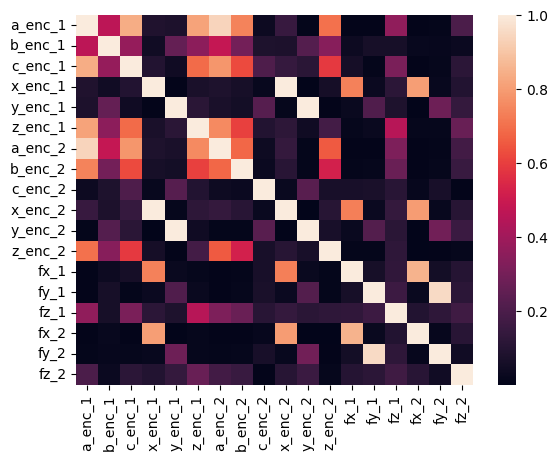

In [6]:
corr_matrix = data.corr().abs()
sns.heatmap(corr_matrix)

### Number of components

To determine the best number of compnents, explained variance ratio is the percentage of variance that is attributed by each of the selected components. My eyeballing the cumunalitve ratio I have chosen 4 components with about 80% to avoid overfitting.

In [7]:
X = data.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
x = StandardScaler().fit_transform(X)
 
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
 
#print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.39447752 0.57709084 0.73956479 0.82447315 0.8860726  0.9424045
 0.97485008 0.99246587 0.99952667]


### Create PCA Train and Test

In [40]:
X = data.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y = data[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]

# standardize
x = (X - X.mean()) / X.std() 
 
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
X_PCA = pd.DataFrame(data = principalComponents)

X_train_PCA = X_PCA.sample(frac = 0.8)
X_test_PCA = X_PCA.drop(X_train_PCA.index)

df = X_train_PCA.join(y, how='left').dropna()
principalComponents

array([[-0.10814279,  2.8809378 ,  1.34366821,  1.28778257],
       [ 0.35959204, -0.81710457,  0.14149917, -0.60478028],
       [-0.04737269,  1.20615636,  0.79977008, -1.10576961],
       ...,
       [ 0.83301888, -1.05343306, -1.38129685,  0.52991417],
       [ 0.67433676, -1.48681343, -1.49245693,  0.31580481],
       [ 0.44195431, -1.65742441, -1.32473359,  0.41493511]])

<Axes: >

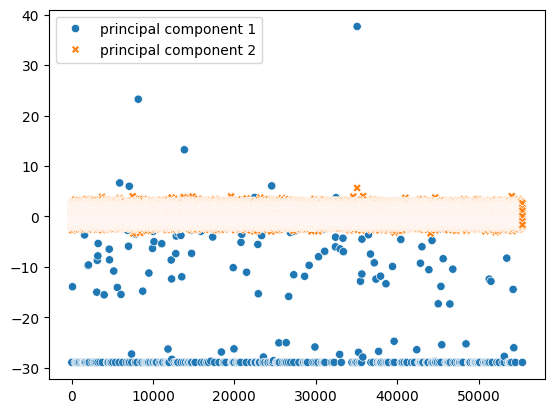

In [58]:
sns.scatterplot(data=principalDf)

## Model Selection
To effectively evaluate various models suitable for our dataset, we employ the cross_val_score method. This method provides a rapid means of assessing model performance using only training data. While not infallible, it serves as a valuable guide in identifying the most promising model.

### Cross-Validation
Given that training occurs solely on training data, there exists a risk of overfitting to this dataset. Cross-validation emerges as a crucial technique to address this concern. By partitioning the data into subsets and systematically training and evaluating the model on different combinations of these subsets, cross-validation offers insights into the model's generalization performance.

### Multivariate Regression Methods
Multivariate Multiple Regression stands as a robust technique for modeling multiple responses or dependent variables using a single set of predictor variables. In our context, the dependent variables encompass various forces, specifically denoted as each robot's 'fx', 'fy', and 'fz'. By leveraging multivariate regression, we aim to discern the relationships between these forces and the predictors, thereby gaining deeper insights into the underlying dynamics.

#### LinearRegression

#### KNeighborsRegressor

#### RandomForestRegressor

In [8]:
cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
model = LinearRegression()
cross_val_score(model, X_train_R1, y_train_R1, cv=cv)

array([0.28606185, 0.28365867, 0.28225582, 0.28628973, 0.27977106])

In [10]:
cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
model = KNeighborsRegressor()
cross_val_score(model, X_train_R1, y_train_R1, cv=cv)

array([0.94366025, 0.94727124, 0.94674917, 0.9447321 , 0.94668505])

In [67]:
model.fit(X_train_R1, y_train_R1)
#evaluate(model, X_test_R1, y_test_R1)

KNeighborsRegressor()

In [11]:
cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
model = RandomForestRegressor(max_depth=5, random_state=0)
cross_val_score(model, X_train_R1, y_train_R1, cv=cv)

array([0.58333645, 0.58453433, 0.57600273, 0.57331584, 0.58502106])

## Hyper parameter search 

In [4]:
%%capture

random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [100, 150, 200, 250]}

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

filename = 'RandomForestRegressor_RandomizedSearchCV_'+time.time()+'.pkl'
pickle.dump(rf_random, open(filename, 'wb'))


param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

filename = 'RandomForestRegressor_GridSearchCV_'+time.time()+'.pkl'
pickle.dump(rf_random, open(filename, 'wb'))

KeyboardInterrupt: 

In [ ]:
%%capture

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

filename = 'RandomForestRegressor_GridSearchCV_'+time.time()+'.pkl'
pickle.dump(rf_random, open(filename, 'wb'))

## Pickel Model 

In [23]:
filename = 'RandomForestRegressor.pkl'
rf_random = pickle.load(open(filename, 'rb'))

In [17]:
filename = 'RandomForestRegressorBestEst.pkl'
rf_random = pickle.load(open(filename, 'rb'))

## Model Evaluation 

In [54]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    MSE = mean_squared_error(y_test, predictions)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Mean Squared Error = {:0.4}.'.format(mean_squared_error(y_test, predictions)))
    print('Root Mean Squared Error = {:0.4}.'.format(np.sqrt(mean_squared_error(y_test, predictions))))
    print('R2 = {:0.4f}.'.format(r2_score(y_test, predictions)))

In [58]:
evaluate(model, X_test_R1, y_test_R1)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/hq/_dmlvc6d2yx_b5dhryhfz2wc0000gn/T/ipykernel_55868/2149614137.py", line 1, in <module>
    evaluate(model, X_test_R1, y_test_R1)
  File "/var/folders/hq/_dmlvc6d2yx_b5dhryhfz2wc0000gn/T/ipykernel_55868/1938847574.py", line 3, in evaluate
    errors = abs(predictions - test_labels)
                 ~~~~~~~~~~~~^~~~~~~~~~~~~
  File "/usr/local/lib/python3.11/site-packages/pandas/core/generic.py", line 2102, in __array_ufunc__
    return arraylike.array_ufunc(self, ufunc, method, *inputs, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py", line 273, in array_ufunc
    result = maybe_dispatch_ufunc_to_dunder_op(self, ufunc, method, *inputs, **kwargs)
             ^^^^^^^^^

In [32]:
evaluate(rf_random, X_test, y_test)

Model Performance
Average Error: 19.9824 degrees.
Accuracy = 93.53%.
Mean Squared Error = 1.606e+03.
Root Mean Squared Error = 40.08.
R2 = 0.9943.
